In [2]:
import gc
from copy import deepcopy
import numpy as np
import pandas as pd
from random import randint

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, TensorBoard
from keras import backend as K
from sklearn.model_selection import TimeSeriesSplit

from datetime import datetime
from keras.models import Model
from keras.models import load_model
from keras.optimizers import Adam, RMSprop
from keras.layers import Input, Conv2D, UpSampling2D, Dropout, LeakyReLU, BatchNormalization, Activation, Add, Subtract
from keras.layers.merge import Concatenate
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
# from keras.applications import VGG16
from keras import initializers
from keras import regularizers
from keras import backend as K

# from libs.pconv_model_UNet import PConvUnet
from keras.models import load_model  

from tqdm import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [3]:
matrix_length = 32

matrix_df = pd.read_csv('./data/trafficV_M.csv', index_col=0, parse_dates=True)

In [4]:
import math
def l2(y_true, y_pred):
    return math.sqrt(np.sum(np.mean(np.square(y_true - y_pred), axis=0))/1024)

# def createTrainArray(week_history_num=0, minute_history_num=0):
#     week_delta_list = [pd.Timedelta(i+1, unit='W') for i in range(week_history_num)]
#     minute_delta_list = [pd.Timedelta((i+1)*15, unit='m') for i in range(minute_history_num)]
#     # 参考历史数据时间点list
#     delta_list = week_delta_list+minute_delta_list
#     print(delta_list)
    
#     set_up_time = pd.Timedelta(week_history_num, unit='W')
#     # 根据历史数据选取多少，重新构建数据集
#     # 相当于去除最开始week_history_num个周的数据，因为这些数据无法找到更前的数据
#     train_df = matrix_df.truncate(before=matrix_df.index.min() + set_up_time)
    
#     train_ago_array_tuple = tuple([np.array(matrix_df.loc[train_df.index - i]).reshape(-1, matrix_length, matrix_length, 1) for i in delta_list])
#     train_df = np.array(train_df).reshape(-1, matrix_length, matrix_length, 1)
#     # concatenate保持 待修复数据在前，参考历史数据在后。与random_mask函数生成mask相一致
#     train_array = np.concatenate((train_df,)+train_ago_array_tuple, axis=3)
#     print(train_array.shape)
#     return train_array


def createTrainArray(week_history_num=0, minute_history_num=0):
    week_delta_list = [pd.Timedelta(week_history_num-i, unit='W') for i in range(week_history_num)]
    minute_delta_list = [pd.Timedelta((minute_history_num-i)*15, unit='m') for i in range(minute_history_num)]
    # 参考历史数据时间点list
    delta_list = minute_delta_list+week_delta_list
    print(delta_list)
    
    set_up_time = pd.Timedelta(week_history_num, unit='W')
    # 根据历史数据选取多少，重新构建数据集
    # 相当于去除最开始week_history_num个周的数据，因为这些数据无法找到更前的数据
    train_df = matrix_df.truncate(before=matrix_df.index.min() + set_up_time)
    
    train_ago_array_tuple = tuple([np.array(matrix_df.loc[train_df.index - i]).reshape(-1, matrix_length, matrix_length, 1) for i in delta_list])
    train_df = np.array(train_df).reshape(-1, matrix_length, matrix_length, 1)
    # concatenate保持 待修复数据在前，参考历史数据在后。与random_mask函数生成mask相一致
    train_array = np.concatenate((train_df,)+train_ago_array_tuple, axis=3)
    print(train_array.shape)
    return train_array

In [5]:
week_history_num = 2
minute_history_num = 3

channel_num = week_history_num +minute_history_num +1
smooth_time = channel_num-1

# train_array为(16704, 32, 32, 3)，16704个矩阵，32*32采集点，3从上到下为当前时间，上一周，上一15min
train_array = createTrainArray(week_history_num, minute_history_num)
X_train, X_test = train_test_split(train_array, test_size = 0.1, random_state=42, shuffle=False)
# X_train, X_val = train_test_split(train_array, test_size = 0.1, random_state=42, shuffle=False) # 不shuffle可用于查看数据正确性

# X_train = train_array[:16704-900-900]
# X_val = train_array[16704-900-900:16704-900]
# X_test = train_array[16704-900:]

[Timedelta('0 days 00:45:00'), Timedelta('0 days 00:30:00'), Timedelta('0 days 00:15:00'), Timedelta('14 days 00:00:00'), Timedelta('7 days 00:00:00')]
(16032, 32, 32, 6)


In [6]:
# 以第一数据为例. 第一列为待预测数据
# 第一例：1.15 0:00  二：1.8 0:00  三：1.1 0:00  四：1.14 23:45  五：1.14 23:30  六：1.14 23:15
# X_train[0]

In [7]:
matrix_shape = (matrix_length, matrix_length, channel_num)
true_volume_shape = (matrix_length, matrix_length, 1)
history_volume_shape = (matrix_length, matrix_length, channel_num-1)

In [8]:
MAX_BATCH_SIZE = 64
epoch_steps = X_train.shape[0] // MAX_BATCH_SIZE
val_steps = X_test.shape[0] // MAX_BATCH_SIZE
epoch_steps, val_steps

(225, 25)

In [9]:
# 加载数据
def load_data(volume_matrix, batch_size=MAX_BATCH_SIZE):
    n_batches=batch_size
    len_of_matrix = len(volume_matrix)

    batch_i = 0
    while ((batch_i+1)*batch_size < len_of_matrix):
        batch_matrix = volume_matrix[batch_i*batch_size: (batch_i+1)*batch_size]
        true_volume, history_volume = batch_matrix[:, :, :, :1], batch_matrix[:, :, :, 1:]
        batch_i+=1

        yield true_volume, history_volume


In [10]:
import math

def l2(y_true, y_pred):
    return math.sqrt(np.sum(np.mean(np.square(y_true - y_pred), axis=0))/1024)

def l1(y_true, y_pred):
    return np.sum(np.mean(np.abs(y_true - y_pred), axis=0))/(matrix_length*matrix_length)

def mape(y_true, y_pred):
    return np.sum(np.mean((np.abs(y_true - y_pred)/y_true)*100, axis=0))/(matrix_length*matrix_length)

In [11]:
kernel_init = 'glorot_uniform'
bias_init = 'zeros'

# kernel_init = initializers.he_uniform()
# bias_init = initializers.he_uniform()
kernel_regul = regularizers.l2(1)
activity_regul = regularizers.l2(1)

learn_rate = 0.0008

# ENCODER
def encoder_layer(img_in, filters, kernel_size, bn=True, resid=True):
    # conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=(1, 1), padding='same')(img_in)
    conv = Conv2D(filters, (kernel_size, kernel_size), padding="same",
       strides=1,kernel_initializer='glorot_uniform')(img_in)
    if bn:
        conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)

    conv = Conv2D(filters, (kernel_size, kernel_size), padding="same",
       strides=1,kernel_initializer='glorot_uniform')(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    return conv

# DECODER
def decoder_layer(img_in, filters, kernel_size, bn=True, resid=True):
    conv = Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding='same',
               kernel_initializer=kernel_init, bias_initializer=bias_init,
              kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(img_in)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)

    conv = Conv2D(filters=filters//2, kernel_size=(3, 3), strides=(1, 1), padding='same',
               kernel_initializer=kernel_init, bias_initializer=bias_init,
              kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)

    conv = UpSampling2D(size = (2,2))(conv)
    return conv


def build_unet(): 
    history_traffic_volume = Input(shape=history_volume_shape)
    
    conv1 = encoder_layer(history_traffic_volume, 32, 3, bn=False)
    pool1 = AveragePooling2D(pool_size=(2, 2))(conv1)

    conv2 = encoder_layer(pool1, 64, 3, bn=True)
    pool2 = AveragePooling2D(pool_size=(2, 2))(conv2)

    conv3 = encoder_layer(pool2, 128, 3, bn=True)
    pool3 = AveragePooling2D(pool_size=(2, 2))(conv3)

    #         conv4 = encoder_layer(pool3, 256, 3, bn=True)
    #         pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = decoder_layer(pool3, 256, 3, bn=True)
    merge1 = Concatenate()([conv3,conv5])

    conv6 = decoder_layer(merge1, 128, 3, bn=True)
    merge2 = Concatenate()([conv2,conv6])

    conv7 = decoder_layer(merge2, 64, 3, bn=True)
    merge3 = Concatenate()([conv1,conv7])

    #         conv8 = decoder_layer(merge3, 32, 3, bn=True)
    #         merge4 = Concatenate()([conv1,conv8])

    conv9 = encoder_layer(merge3, 32, 3, bn=False)


    model_output =  Conv2D(1, 1, activation = 'relu', kernel_initializer=kernel_init, bias_initializer=bias_init,
                  kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(conv9)

    # Setup the model inputs / outputs
    model = Model(inputs=history_traffic_volume, outputs=model_output)

    # Compile the model
    model.compile(
        optimizer = RMSprop(lr=learn_rate),
        loss='mse'
    )

    return model

In [12]:
unet = build_unet()

In [13]:
lr_step = []
l2_validation = []

def train(train_matrix, epochs, batch_size=MAX_BATCH_SIZE, learn_rate=0.01):

    start_time = datetime.now()
    min_mse=999
    print("train start "+str(start_time))

    for epoch in range(epochs):
#         if epoch>6 and epoch % 1 == 0 and epoch != 0:
#             unet_lr = K.get_value(unet.optimizer.lr)
#             if unet_lr>0.001:
#                 K.set_value(unet.optimizer.lr, unet_lr*0.3)
#             if unet_lr>0.0001:
#                 if epoch%5==0:
#                     K.set_value(unet.optimizer.lr, unet_lr*0.8)
                
        for batch_i, (true_volume, history_volume) in enumerate(load_data(train_matrix,batch_size)):
            # true_volume 真实待预测路网交通量  history_volume 路网交通量历史数据
            #  训练 unet
            #  训练 Generator
            g_loss = unet.train_on_batch(history_volume, true_volume)


        elapsed_time = datetime.now() - start_time
        # Plot the progress
        y_pred = unet.predict(X_test[:, :, :, 1:])
        y_true = X_test[:, :, :, :1]

        l2_epoch_validation = l2(y_true, y_pred)
        l1_epoch_validation = l1(y_true, y_pred)
        
        y_pred[y_true==0] += 1
        y_true[y_true==0] += 1
        mape_epoch_validation = mape(y_true, y_pred)
        
        lr_step.append(K.get_value(unet.optimizer.lr))
        l2_validation.append(l2_epoch_validation)
        
        if(l2_epoch_validation<30 and l2_epoch_validation<min_mse):
            unet.save_weights('./model/RUnet/tmp/unet_forecast.h5')
            min_mse = l2_epoch_validation
            
        l2_validation.append(l2_epoch_validation)
        if epoch%1==0:
#             print("unet lr:"+ str(K.get_value(unet.optimizer.lr)))
            print ("[Unet %d/%d]  [mse: %f] [mae: %f] [mape: %f] [G loss: %f] time: %s" % (epoch+1, epochs,
                                                                    l2_epoch_validation,
                                                                    l1_epoch_validation,
                                                                    mape_epoch_validation,
                                                                    g_loss,
                                                                    elapsed_time))

In [14]:
# train(X_train, epochs=100, batch_size=MAX_BATCH_SIZE, learn_rate=learn_rate)

In [15]:
# unet.save_weights('./model/RUnet/unet_60epoch_18rmse.h5')
unet.load_weights('./model/RUnet/unet_rmse20.2_final/runet_forecast_20.2.h5')

In [16]:
y_pred = unet.predict(X_test[:, :, :, 1:])
y_true = X_test[:, :, :, :1]

l2(y_true, y_pred)

20.19168143759424

In [17]:
# every_rmse = np.sqrt(np.mean(np.square(y_true - y_pred), axis=0))
# every_mae = np.mean(np.abs(y_true - y_pred), axis=0)
# every_mape = np.mean((np.abs(y_true - y_pred)/y_true), axis=0)

# import pickle
# with open('./data/实验结果数据/unet_everyObservationr_rmse.data','wb') as f:
#     pickle.dump(every_rmse,f)
    
# with open('./data/实验结果数据/unet_everyObservationr_mae.data','wb') as f:
#     pickle.dump(every_mae,f)
    
# with open('./data/实验结果数据/unet_everyObservationr_mape.data','wb') as f:
#     pickle.dump(every_mape,f)

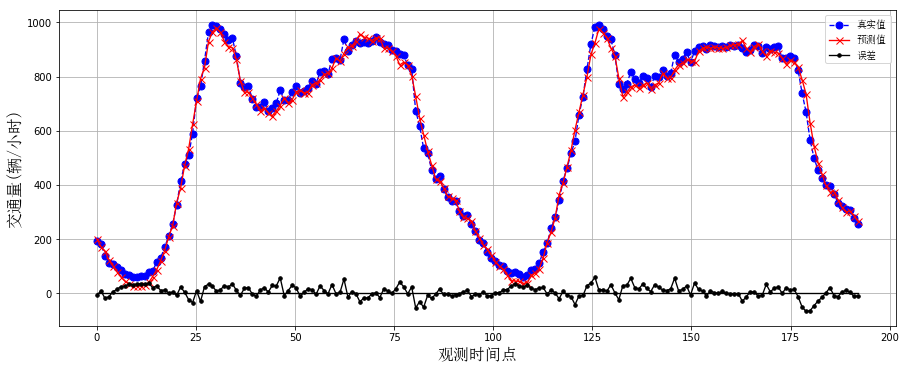

In [18]:
# 实验一

import matplotlib as mpl
from matplotlib.patches import Ellipse
# del mpl.font_manager.weight_dict['roman']
# mpl.font_manager._rebuild()

from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc")
fontsz = 16

posX = 19
posY = 25
startX = 1220
gapX = 192

zero_line = np.random.randint(0, 1, (gapX,))

y = y_true[:, posX, posY, :][startX: startX+gapX]
yf = y_pred[:, posX, posY, :][startX: startX+gapX]
x = np.linspace(0, len(y), len(y))

fig, ax = plt.subplots(figsize=(15, 5.8))
lines = plt.plot(x, y, x, yf, x,y-yf, x,zero_line)
l1, l2, l3, l4 = lines

plt.setp(lines, markersize=7, linewidth=1.34)
plt.setp(l1, color='b', linestyle='--', marker='o')  # line1 is thick and red
plt.setp(l2, color='r', linestyle='-', marker='x')  # line2 is thinner and green
plt.setp(l3, color='k', linestyle='-', marker='.')  # line2 is thinner and green
plt.setp(l4, color='k', linestyle='-')  # line2 is thinner and green

plt.ylabel('交通量(辆/小时)', fontproperties=font, fontsize=fontsz)
plt.xlabel('观测时间点', fontproperties=font, fontsize=fontsz)
ax.yaxis.grid(True)
ax.xaxis.grid(True)
y_major_locator=plt.MultipleLocator(200)
ax.yaxis.set_major_locator(y_major_locator)

qwe = range(0,2000,500)
# plt.yticks(qwe, ('0', '500', '1000', '1500'))
ax.legend(('真实值', '预测值', '误差'), prop=font, loc=1)


# ax.legend(('Expected', 'Predicted', 'Error'), prop=font, loc=1)
plt.rcParams.update({'font.size': fontsz-2})
plt.rc('font',family='Times New Roman')
# plt.savefig("./pic/unet两日预测英文.png", dpi=500)
plt.show()

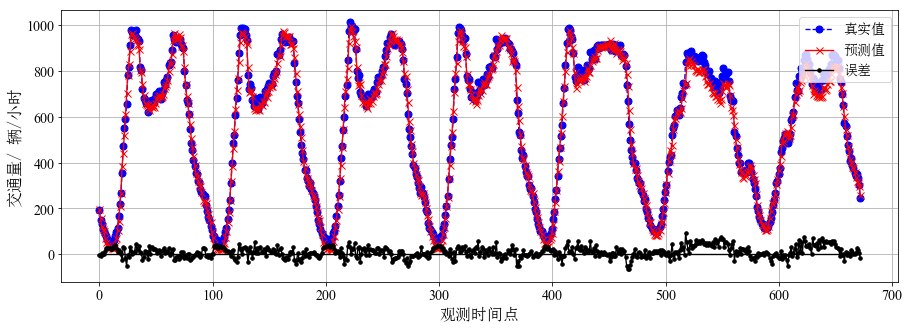

In [19]:
import matplotlib as mpl
# del mpl.font_manager.weight_dict['roman']
# mpl.font_manager._rebuild()

from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc")
fontsz = 16

# posX = 21
# posY = 27
startX = 932
gapX = 672

zero_line = np.random.randint(0, 1, (gapX,))

y = y_true[:, posX, posY, :][startX: startX+gapX]
yf = y_pred[:, posX, posY, :][startX: startX+gapX]
x = np.linspace(0, len(y), len(y))

fig, ax = plt.subplots(figsize=(15, 5))
lines = plt.plot(x, y, x, yf, x,y-yf, x,zero_line)
l1, l2, l3, l4 = lines

plt.setp(lines, markersize=7, linewidth=1.34)
plt.setp(l1, color='b', linestyle='--', marker='o')  # line1 is thick and red
plt.setp(l2, color='r', linestyle='-', marker='x')  # line2 is thinner and green
plt.setp(l3, color='k', linestyle='-', marker='.')  # line2 is thinner and green
plt.setp(l4, color='k', linestyle='-')  # line2 is thinner and green

plt.ylabel('交通量/ 辆/小时', fontproperties=font, fontsize=fontsz)
plt.xlabel('观测时间点', fontproperties=font, fontsize=fontsz)
ax.yaxis.grid(True)
ax.xaxis.grid(True)
y_major_locator=plt.MultipleLocator(200)
ax.yaxis.set_major_locator(y_major_locator)

qwe = range(0,2000,500)
# plt.yticks(qwe, ('0', '500', '1000', '1500'))
ax.legend(('真实值', '预测值', '误差'), prop=font, fontsize=fontsz-10, loc=1)
# ax.legend(('Expected', 'Predicted', 'Error'), prop=font, loc=1)
plt.rcParams.update({'font.size': fontsz-2})
plt.rc('font',family='Times New Roman')
# plt.savefig("./pic/毕设/实验一runet一周预测.png", dpi=300)
plt.show()

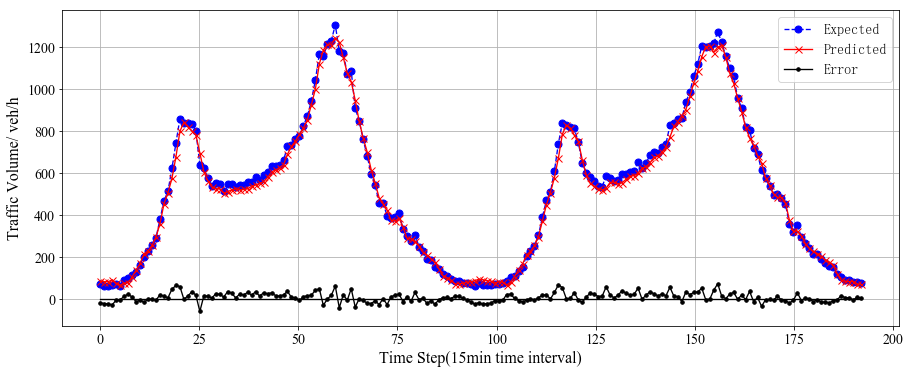

In [20]:
# 实验二

import matplotlib as mpl
# del mpl.font_manager.weight_dict['roman']
# mpl.font_manager._rebuild()

from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc")
fontsz = 16

posX = 21
posY = 27
startX = 1230
gapX = 192

zero_line = np.random.randint(0, 1, (gapX,))

y = y_true[:, posX, posY, :][startX: startX+gapX]
yf = y_pred[:, posX, posY, :][startX: startX+gapX]
x = np.linspace(0, len(y), len(y))

fig, ax = plt.subplots(figsize=(15, 5.8))
lines = plt.plot(x, y, x, yf, x,y-yf, x,zero_line)
l1, l2, l3, l4 = lines

plt.setp(lines, markersize=7, linewidth=1.34)
plt.setp(l1, color='b', linestyle='--', marker='o')  # line1 is thick and red
plt.setp(l2, color='r', linestyle='-', marker='x')  # line2 is thinner and green
plt.setp(l3, color='k', linestyle='-', marker='.')  # line2 is thinner and green
plt.setp(l4, color='k', linestyle='-')  # line2 is thinner and green

# plt.ylabel('交通量/ 辆/小时', fontproperties=font, fontsize=fontsz)
plt.ylabel('Traffic Volume/ veh/h', fontsize=fontsz)

# plt.xlabel('观测时间点', fontproperties=font, fontsize=fontsz)
plt.xlabel('Time Step(15min time interval)', fontsize=fontsz)
ax.yaxis.grid(True)
ax.xaxis.grid(True)
y_major_locator=plt.MultipleLocator(200)
ax.yaxis.set_major_locator(y_major_locator)


qwe = range(0,2000,500)
# plt.yticks(qwe, ('0', '500', '1000', '1500'))
# ax.legend(('真实值', '预测值', '误差'), prop=font, loc=1)
ax.legend(('Expected', 'Predicted', 'Error'), prop=font, loc=1)
plt.rcParams.update({'font.size': fontsz-2})
plt.rc('font',family='Times New Roman')
plt.savefig("./pic/unet两日预测英文.png", dpi=500)
plt.show()

路网采集点平均mape分布

633

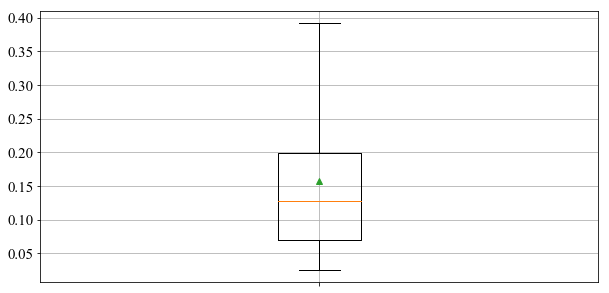

In [22]:
# 路网采集点平均mape分布
import seaborn as sns

font_size=15
plt.rcParams.update({'font.size': font_size})
fig, ax = plt.subplots(figsize=(10, 5))
x_labels=['']
spacial_mape = (np.mean(np.abs(y_true-y_pred)/y_true, axis=0)).reshape(1024)

bplot = ax.boxplot(spacial_mape, sym='x', patch_artist=False, vert=True, showmeans=True, labels=x_labels, showfliers=False)
# sns.violinplot(data=spacial_mape, palette="Set3", bw=0.1, cut=1, linewidth=1)

plt.grid(True)
np.sum(spacial_mape>0.1)

In [57]:
sum(spacial_mape<0.39271)/1024


0.9619140625

In [50]:
# 箱图具体数据
print('中位数'+ str(np.median(spacial_mape)))
q1 = np.percentile(spacial_mape, 25)
print('25%分位数'+ str(q1))
q3 = np.percentile(spacial_mape, 75)
print('75%分位数'+ str(q3))

#四分位距IQR=Q3-Q1，那么上限=Q3+1.5IQR，下限=Q1-1.5IQR
print('上限'+ str(q3+1.5*(q3-q1)))
print('下限'+ str(q1-1.5*(q3-q1)))

中位数0.1282612532678088
25%分位数0.06918992984111196
75%分位数0.19859800250152143
上限0.39271011149213564
下限-0.12492217914950228


In [40]:
# 最大最小值分10区间进行统计
np.histogram(spacial_mape,bins=10)

(array([820, 166,  18,  12,   3,   1,   0,   1,   2,   1], dtype=int64),
 array([0.02525705, 0.21338985, 0.40152266, 0.58965547, 0.77778828,
        0.96592109, 1.1540539 , 1.3421867 , 1.53031951, 1.71845232,
        1.90658513]))

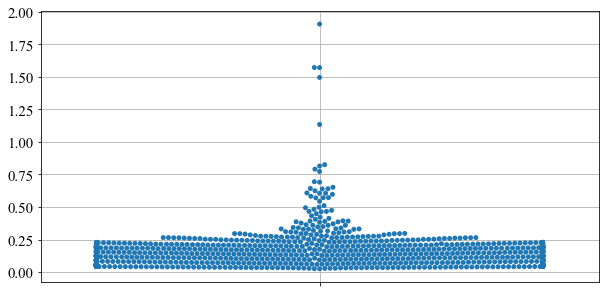

In [23]:
# 路网采集点平均mape分布

plt.rcParams.update({'font.size': font_size})
fig, ax = plt.subplots(figsize=(10, 5))
x_labels=['']
spacial_mape = (np.mean(np.abs(y_true-y_pred)/y_true, axis=0)).reshape(1024)

sns.swarmplot(data=spacial_mape, size=5)

ax.set_xticklabels(x_labels)

plt.grid(True)

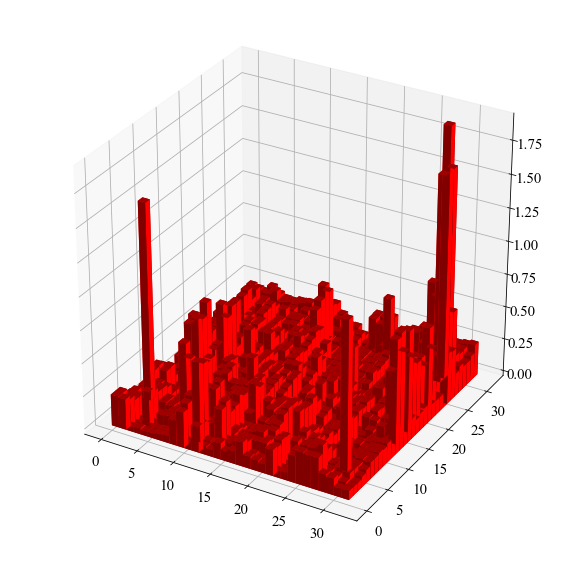

In [25]:
from matplotlib import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as mp
from matplotlib.colors import LightSource

# spacial_volume = (y_true)[startX+50].reshape(32*32)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
 
x = np.array([])
for i in range(32):
    tmp = np.ones(32)*i
    x = np.hstack((x,tmp))
y = np.arange(0,1024)%32

bottom = np.zeros_like(spacial_mape)
width = depth = 1
ax.bar3d(x, y, bottom, width, depth, spacial_mape, shade=True, color='r')

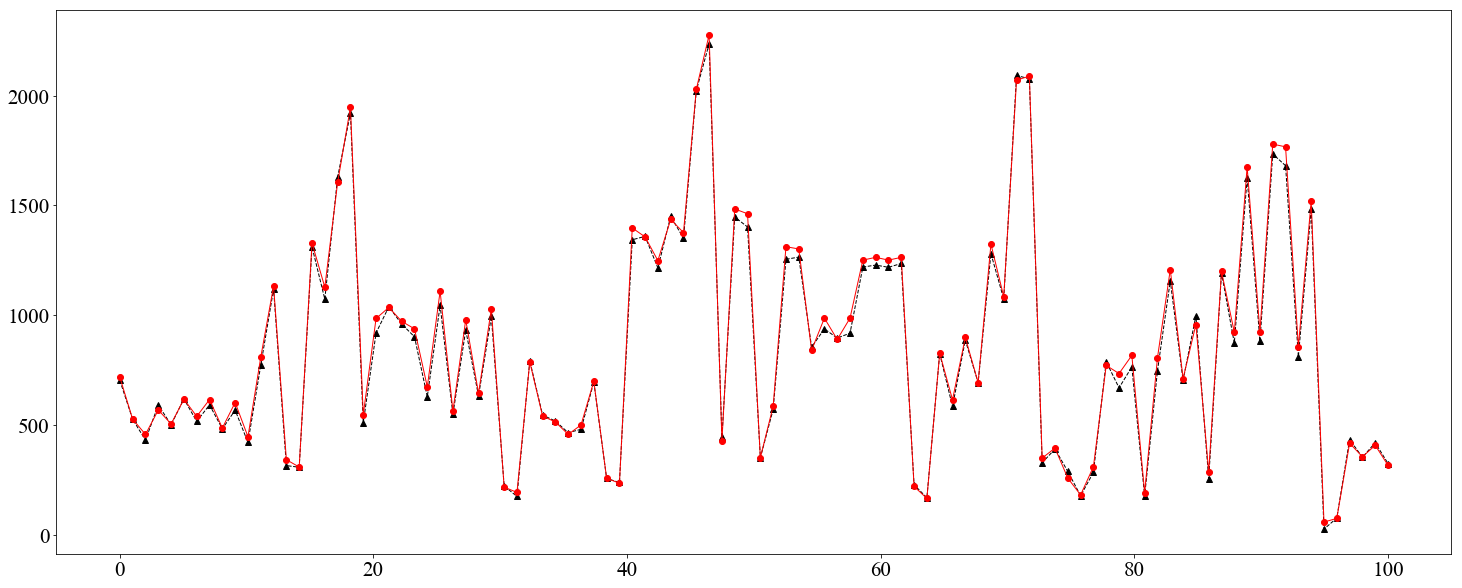

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt

start_time = 1600
y = y_true.reshape(-1,)[start_time: start_time+100]
x = np.linspace(0, len(y), len(y))

yi = y_pred.reshape(-1,)[start_time: start_time+100]
xi = np.linspace(0, len(yi), len(yi))
fig, ax = plt.subplots(figsize=(25, 10))
# ax.plot(x, y, '.', linewidth=1, markersize=10)
lines = plt.plot(xi, yi, 'k^--', x, y, 'ro-',linewidth=1, markersize=6)
plt.show()

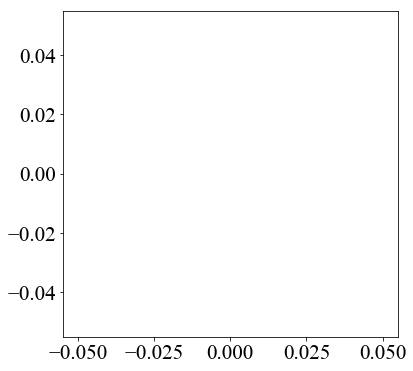

In [19]:
yi = l2_validation
xi = np.linspace(0, len(yi), len(yi))
fig, ax = plt.subplots(figsize=(6, 6))
lines = plt.plot(xi, yi, 'k^--', linewidth=1, markersize=6)
plt.show()

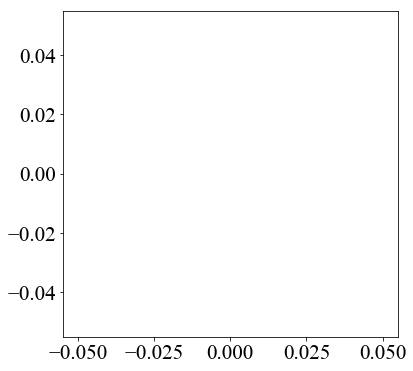

In [20]:
y = lr_step
x = np.linspace(0, len(y), len(y))
fig, ax = plt.subplots(figsize=(6, 6))
lines = plt.plot(x, y, 'ko-', linewidth=1, markersize=6)

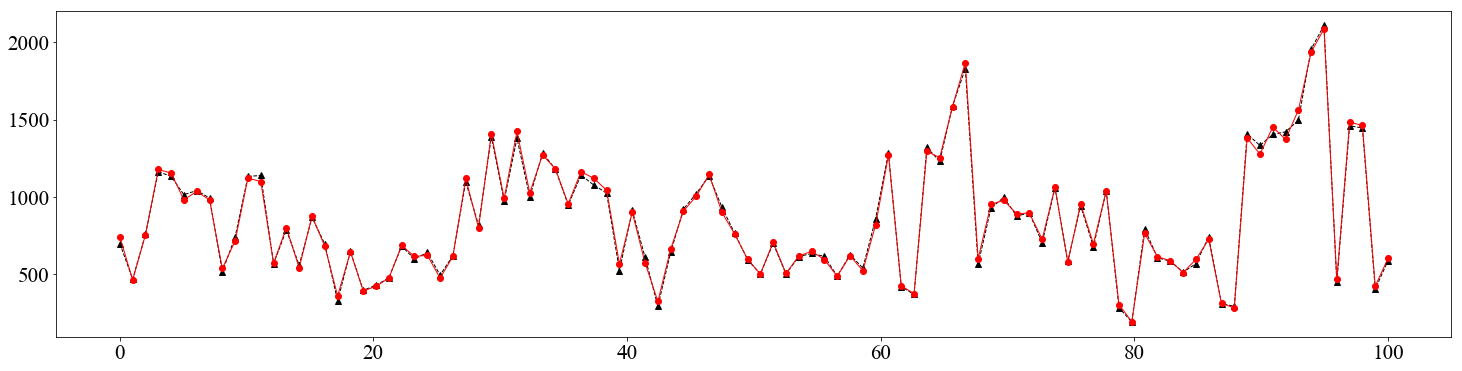

In [21]:
start_time = 3600
y = y_true.reshape(-1,)[start_time: start_time+100]
x = np.linspace(0, len(y), len(y))

yi = y_pred.reshape(-1,)[start_time: start_time+100]
xi = np.linspace(0, len(yi), len(yi))
fig, ax = plt.subplots(figsize=(25, 6))
# ax.plot(x, y, '.', linewidth=1, markersize=10)
lines = plt.plot(xi, yi, 'k^--', x, y, 'ro-',linewidth=1, markersize=6)
plt.show()

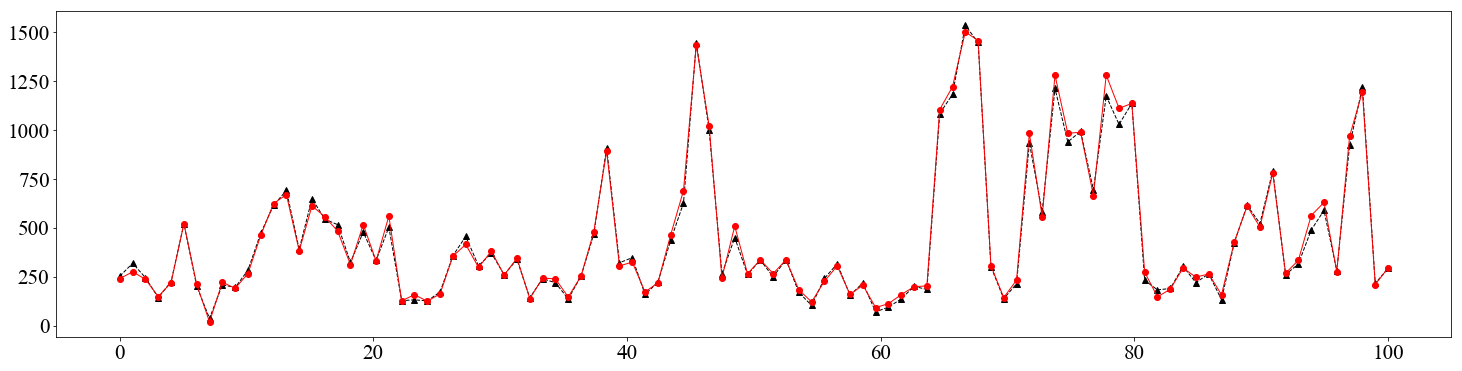

In [22]:
start_time = 0
y = y_true.reshape(-1,)[start_time: start_time+100]
x = np.linspace(0, len(y), len(y))

yi = y_pred.reshape(-1,)[start_time: start_time+100]
xi = np.linspace(0, len(yi), len(yi))
fig, ax = plt.subplots(figsize=(25, 6))
# ax.plot(x, y, '.', linewidth=1, markersize=10)
lines = plt.plot(xi, yi, 'k^--', x, y, 'ro-',linewidth=1, markersize=6)
plt.show()

In [23]:
y_pred

array([[[[ 253.59225  ],
         [ 319.3869   ],
         [ 245.21548  ],
         ...,
         [ 371.85352  ],
         [ 260.58023  ],
         [ 338.66248  ]],

        [[ 142.74275  ],
         [ 240.76195  ],
         [ 219.64511  ],
         ...,
         [ 136.95752  ],
         [ 201.42932  ],
         [ 185.24197  ]],

        [[1084.9082   ],
         [1182.6783   ],
         [1535.392    ],
         ...,
         [ 489.1877   ],
         [ 589.53455  ],
         [ 281.66412  ]],

        ...,

        [[ 611.2302   ],
         [ 406.92743  ],
         [ 419.0206   ],
         ...,
         [  86.16091  ],
         [ 110.39123  ],
         [ 136.89131  ]],

        [[1065.3777   ],
         [1255.3958   ],
         [1009.79944  ],
         ...,
         [ 127.942795 ],
         [ 108.82973  ],
         [ 147.58273  ]],

        [[ 737.7117   ],
         [ 517.86273  ],
         [1108.6864   ],
         ...,
         [ 347.6898   ],
         [  95.429306 ],
         [ 173.83

In [24]:
y_true

array([[[[ 241.  ],
         [ 275.5 ],
         [ 237.5 ],
         ...,
         [ 381.  ],
         [ 258.5 ],
         [ 345.75]],

        [[ 138.5 ],
         [ 243.25],
         [ 239.5 ],
         ...,
         [ 159.  ],
         [ 199.5 ],
         [ 203.5 ]],

        [[1105.  ],
         [1222.  ],
         [1502.  ],
         ...,
         [ 563.25],
         [ 630.38],
         [ 276.88]],

        ...,

        [[ 614.5 ],
         [ 423.5 ],
         [ 447.  ],
         ...,
         [ 113.5 ],
         [ 151.  ],
         [ 156.5 ]],

        [[1108.  ],
         [1287.  ],
         [1023.25],
         ...,
         [ 132.  ],
         [ 151.  ],
         [ 156.5 ]],

        [[ 737.  ],
         [ 514.25],
         [1133.5 ],
         ...,
         [ 352.5 ],
         [ 118.5 ],
         [ 178.5 ]]],


       [[[ 279.5 ],
         [ 305.  ],
         [ 215.  ],
         ...,
         [ 414.5 ],
         [ 363.  ],
         [ 381.75]],

        [[ 179.  ],
         [ 2